# Recovering the Population Parameters using SAEM

We will use the Stochastic Approximation of the Expectation Maximisation algorithm used in Monolix and NONMEM to recover the population parameters of the model.

The model that was used to generate the data was the following hierarchical model:

Structural model:

$\dot{x}_{\text{dose}} = -K_a x_{\text{dose}} + \text{DOSE}$

$\dot{x}_{\text{central}} = K_a x_{\text{dose}} - \frac{CL}{V_c} x_{\text{central}}$

$y = \frac{x_{\text{central}}}{V_{c}} + \varepsilon $,

where $\varepsilon \sim \mathcal{N}(0, \sigma ^2)$ was the measurement noise, and the statistical model

$CL \sim \mathcal{N}(CL_{\text{pop}}, \Omega ^2_{CL})$

$V_{c} \sim \mathcal{N}(V_{c,\text{pop}}, \Omega ^2_{V})$

$K_{a} \sim \mathcal{N}(K_{a, \text{pop}}, \Omega ^2_{K})$.

The dataset consists of 9 individuals which where generated with the population parameters

$\sigma = 0.1$

$CL_{\text{pop}} = 2$ 

$\Omega _{CL} = 0.1$ 

$V_{c,\text{pop}} = 1$ 

$\Omega _{V} = 0.2$

$K_{a, \text{pop}} = 3$ 

$\Omega _{K} = 0.2$.

### Looking at the data

The dataset contains 9 individuals and looks as follows:

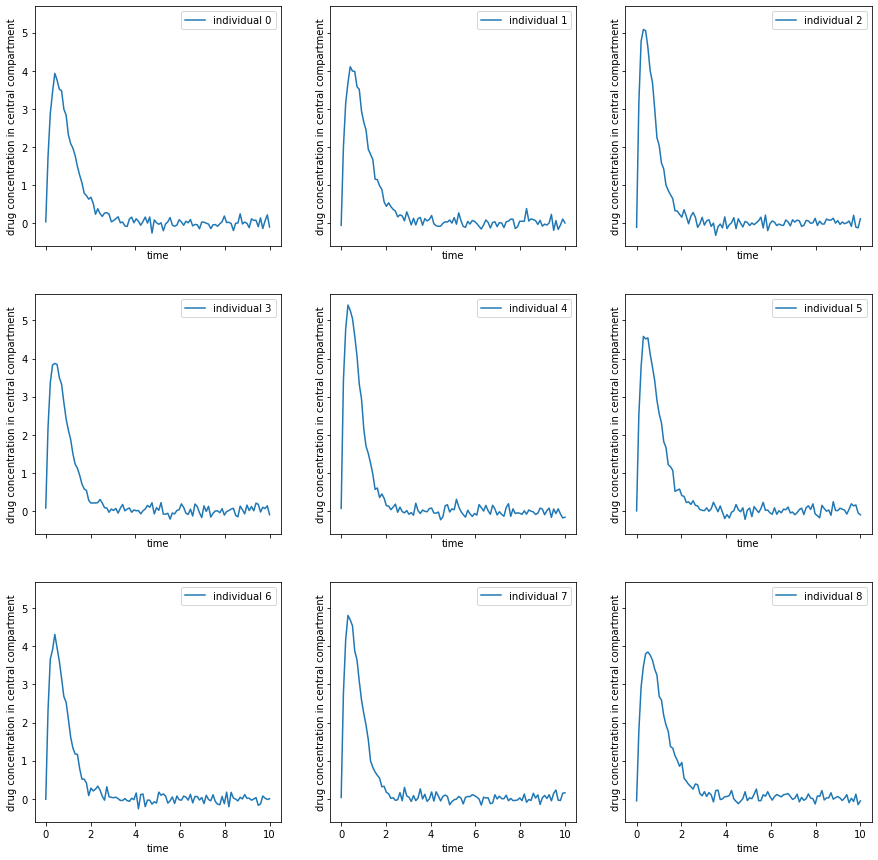

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# load data
fullData = np.loadtxt(fname='data.csv', delimiter=',', skiprows=0)
times = fullData[:, 0]
data = fullData[:, 1:].T

# visualise individuals
# plot
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15,15), sharex=True, sharey=True)

for ID, individual in enumerate(data):
    row = ID // 3
    col = ID % 3

    ax[row, col].plot(times, individual, label='individual %d' % ID)
    ax[row, col].set_xlabel('time')
    ax[row, col].set_ylabel('drug concentration in central compartment')
    ax[row, col].legend()

plt.show()

### Getting the estimates the quick and dirty way

Before we dive into somewhat complicated algorithms like SAEM let's try to recover the parameters by first estimating the maximum likelihood estimates (MLE) of the individual parameters, by looking at each individual separately, and then use those fixed values to get a MLE for the population parameters. We can do this with the following steps

1. Define the structrual model in pints
2. Solve the individual inverse problems with the pints.OptimisationController to find the MLE of the indiviudal parameters
3. Construct a pints model that simply returns the population mean parameter and use the log-likelihood feature of pints to find the MLE of the population parameters.

In [2]:
# 1. Define pints model
import myokit
import pints

class PintsModel(pints.ForwardModel):
    def __init__(self):
        # load model
        model, protocol, _ = myokit.load('OneCompartmentLinearSc.mmt')

        # create simulator
        self.sim = myokit.Simulation(model, protocol)

    def n_parameters(self):
        """
        Number of parameters to fit. Here CL, Vc, Ka
        """
        return 3

    def n_outputs(self):
        return 1

    def simulate(self, parameters, times):
        # set up simulation
        self.sim.reset()
        self.sim.set_time(0)
        self.sim.set_state([0, 0])  # sets initial drug amounts to zero
        cl, vc, ka = np.exp(parameters)
        self.sim.set_constant('centralCompartment.CL', cl)
        self.sim.set_constant('centralCompartment.Vc', vc)
        self.sim.set_constant('doseCompartment.Ka', ka)

        # only log concentration
        loggedVariable = 'centralCompartment.drugConcentration'

        # simulate for given dose
        doseAmount = 10000
        self.sim.set_constant('dose.doseAmount', float(doseAmount))
        output = self.sim.run(times[-1] + 1, log=[loggedVariable], log_times=times)
        result = output[loggedVariable]

        return np.array(result)

In [3]:
# 2. Get MLE for individual params
# define likelihood
model = PintsModel()

# find MLE for individual params
individualEstimates = np.empty(shape=(9, 4))
for idd, individualData in enumerate(data):
    problem = pints.SingleOutputProblem(model, times, individualData)
    likelihood = pints.GaussianLogLikelihood(problem)
    
    # get estimates
    opt = pints.OptimisationController(
        function=likelihood, 
        x0=[1, 1, 1, 1],  # initial guess for CL, Vc, Ka, sigma
        method = pints.CMAES)
    estimate, _ = opt.run()
    
    # save estimates
    individualEstimates[idd, :] = estimate

print()
print('Estimate of sigma ', np.mean(individualEstimates[:, 3]))
print('True value: ', 0.1)

Maximising LogPDF
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 8
Iter. Eval. Best      Time m:s
0     8     -36.21137   0:00.0


/Users/david/Workspace/sabs-r3/DPhil/Journal Club/SAEM/venv/lib/python3.7/site-packages/pints/_log_likelihoods.py:519: RuntimeWarning: invalid value encountered in log
  - np.sum(error**2, axis=0) / (2 * sigma**2))


1     16    -11.5209    0:00.1
2     24     53.62586   0:00.1
3     32     53.62586   0:00.1
20    168    87.90515   0:00.3
40    328    94.4832    0:00.5
60    488    94.50964   0:00.8
80    648    94.50971   0:01.0
100   808    94.50971   0:01.2
120   968    94.50971   0:01.4
140   1128   94.50971   0:01.7
160   1288   94.50971   0:01.9
180   1448   94.50971   0:02.1
200   1608   94.50971   0:02.3
220   1768   94.50971   0:02.6
240   1928   94.50971   0:02.8
260   2088   94.50971   0:03.0
280   2248   94.50971   0:03.2
300   2408   94.50971   0:03.5
320   2568   94.50971   0:03.7
340   2728   94.50971   0:03.9
360   2888   94.50971   0:04.1
380   3048   94.50971   0:04.3
400   3208   94.50971   0:04.5
420   3368   94.50971   0:04.8
440   3528   94.50971   0:05.0
460   3688   94.50971   0:05.2
480   3848   94.50971   0:05.4
500   4008   94.50971   0:05.6
520   4168   94.50971   0:05.8
540   4328   94.50971   0:06.0
560   4488   94.50971   0:06.3
580   4648   94.50971   0:06.5
597   47

100   808    97.28372   0:01.1
120   968    97.28373   0:01.3
140   1128   97.28373   0:01.5
160   1288   97.28373   0:01.7
180   1448   97.28373   0:01.9
200   1608   97.28373   0:02.1
220   1768   97.28373   0:02.3
240   1928   97.28373   0:02.5
260   2088   97.28373   0:02.7
280   2248   97.28373   0:02.9
300   2408   97.28373   0:03.1
320   2568   97.28373   0:03.4
340   2728   97.28373   0:03.6
360   2888   97.28373   0:03.8
362   2896   97.28373   0:03.8
Halting: No significant change for 200 iterations.

Estimate of sigma  0.09682054770941455
True value:  0.1


In [12]:
# 3. Get MLE for poulations parameters
# define model
class PopulationModel(pints.ForwardModel):
    def n_parameters(self):
        """
        Number of parameters to fit. Here CL, Vc, Ka
        """
        return 1

    def n_outputs(self):
        return 1

    def simulate(self, mean, psi):
        return np.full(fill_value=mean, shape=len(psi))
    
# Instantiate model
popModel = PopulationModel()

# make up times (don't matter here)
times = np.linspace(0, 1, 9)

# population params
popParam = ['CL', 'Vc', 'Ka']
true_mean = [2, 1, 3]
true_std = [0.1, 0.2, 0.2]

# Compute estimates
estimate_container = []
for paramId, param in enumerate(popParam): 
    problem = pints.SingleOutputProblem(popModel, times, individualEstimates[:, paramId])
    log_likelihood = pints.GaussianLogLikelihood(problem)
    opt = pints.OptimisationController(
        function=log_likelihood, 
        x0=[1.5, 1],  # initial guess for mean and variance
        method = pints.CMAES)
    estimate, _ = opt.run()
    
    # save estimates
    estimate_container.append(estimate)

    print()
    print('Estimate %s: ' % param, np.exp(estimate[0]))
    print('True value: ', true_mean[paramId])
    print()
    print('Estimate Omega %s: ' % param, estimate[1])
    print('True value: ', true_std[paramId])
    print()

Maximising LogPDF
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 6
Iter. Eval. Best      Time m:s
0     6     -8.763228   0:00.0
1     12    -6.235964   0:00.0
2     18    -5.744322   0:00.0
3     24    -5.744322   0:00.0
20    126    9.684946   0:00.0
40    246    10.64938   0:00.1
60    366    10.65036   0:00.1
80    486    10.65036   0:00.1
100   606    10.65036   0:00.1
120   726    10.65036   0:00.1
140   846    10.65036   0:00.2
160   966    10.65036   0:00.2
180   1086   10.65036   0:00.2
200   1206   10.65036   0:00.2
220   1326   10.65036   0:00.3
240   1446   10.65036   0:00.3
260   1566   10.65036   0:00.3
276   1656   10.65036   0:00.3
Halting: No significant change for 200 iterations.

Estimate CL:  2.1039369725097727
True value:  2

Estimate Omega CL:  0.074102096714291
True value:  0.1

Maximising LogPDF
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 

So just by running this very simplistic estimation routine, we can recover the parameters reasonably well. Note that the values below are from a previous run, so they don't necessarily coincide with the values above.

<div style="-webkit-column-count: 2; -moz-column-count: 2; column-count: 2; -webkit-column-rule: 1px dotted #e0e0e0; -moz-column-rule: 1px dotted #e0e0e0; column-rule: 1px dotted #e0e0e0;">
    <div style="display: inline-block;">
        <h2>True Population Parameters </h2>
        <br />
        $\sigma = 0.1$<br /><br />
        $CL_{\text{pop}} = 2$<br /><br />      
        $\Omega _{CL} = 0.1$<br /><br /> 
        $V_{c,\text{pop}} = 1$<br /><br /> 
        $\Omega _{V} = 0.2$<br /><br />
        $K_{a, \text{pop}} = 3$<br /><br /> 
        $\Omega _{K} = 0.2$        
    </div>
    <div style="display: inline-block;">
        <h2>Estimated Population Parameters </h2>
        <br /> 
        $\sigma = 0.0968255924679375$<br /><br /> 
        $CL_{\text{pop}} = 2.1040079310515125$<br /><br />       
        $\Omega _{CL} = 0.07408847946996566$<br /><br />  
        $V_{c,\text{pop}} = 0.8390789901008985$<br /><br />  
        $\Omega _{V} = 0.20211290958013492$<br /><br /> 
        $K_{a, \text{pop}} = 2.55898134379874$<br /><br />  
        $\Omega _{K} = 0.1622404612538337$  
    </div>
</div>

Note that this method does not leverage the hierarchical structure of the model at any time. For example, if one individual had only a couple measuremts, the MLE estimates for this individual would be really bad and will negatively influence the population parameter estimates. In the extreme case where each individual did only have very few data points, such that the individual parameters would actually be underdetermined, we would not be able to recover the population parameters at all! An additional problem is, that the maximium lieklihood estimates don't tell us anything about the uncertainty in the population parameters. So how can we know whether the estimates are good or not? Let's have a look how SAEM deals with this problem.

### Notation

To expain the SAEM algorithm that we will use to recover the parameters, we will use a more shorthand notation, which we will try to introduce step by step below. Imagine we considered only one individual and the structural model parameters $\psi = (CL, V_c, K_a)$ were fixed, then we could summarise the entire model by a single probability distribution

$\text{p}(y;\psi, \sigma ^2) = \frac{1}{\sqrt{2\pi \sigma ^2)}}\text{e}^{-\left( y-\frac{x_{\text{central}}(\psi)}{V_c}\right) ^2/2\sigma ^2}$,

as according to $y = \frac{x_{\text{central}}}{V_{c}} + \varepsilon $, the observatios should be centered around $x_{\text{central}}/V_{c}$ where $x_{\text{central}}$ depends on the structural model parameters $\psi $, and will deviate from that mean with the variance $\sigma ^2 $. The $(\cdot ; \cdot )$ notation separates the random variables from the deterministic ones, i.e. $y$ random, and $\psi, \sigma ^2$ deterministic.

We are, however, not interested in one individual but in the hierarchical, population model. So the $\psi $ are now random and are drawn from a population distribution that describes the inter-individual variability. Thus the above structural model just changes in that we have to explicitly fix the structural parameters $\psi $ by conditioning on them

$\text{p}(y_i|\psi _i; \sigma ^2) = \frac{1}{\sqrt{2\pi \sigma ^2)}}\text{e}^{-\left( y-\frac{x_{\text{central}}(\psi _i)}{V_{c,i}}\right) ^2/2\sigma ^2}$.

As you can see, the right hand side hasn't changed, because once the parameters for an individual are known, we can compute the observations with the exact same distribution as before. The full structural model for all 9 individuals is then given by the product of the individual probabilities, since we assume that the individuals are independent (this makes sense as long as the individuals are not related to each other)

$\text{p}(y|\psi ; \sigma ^2) =\Pi _{i=1}^9\text{p}(y_i|\psi _i, \sigma ^2)$, 

where now $y = (y_1, y_2, \ldots ,y_9)$ and $\psi = (\psi_1, \psi_2, \ldots ,\psi_9)$. 

The statistical model describes how the structural parameters are distributed over the population

$\text{p}(\psi_i; CL_{\text{pop}}, \Omega _{CL}, V_{c,\text{pop}}, \Omega _{V}, K_{a, \text{pop}}, \Omega _{K})= \frac{1}{\sqrt{2\pi \Omega _{CL} ^2}}\text{e}^{-\left( CL_i-CL_{\text{pop}}\right) ^2/2\Omega _{CL} ^2} \frac{1}{\sqrt{2\pi \Omega _{V} ^2}}\text{e}^{-\left( V_{c,i}-V_{c,\text{pop}}\right) ^2/2\Omega _{V} ^2} \frac{1}{\sqrt{2\pi \Omega _{K} ^2}}\text{e}^{-\left( K_{a,i}-K_{a,\text{pop}}\right) ^2/2\Omega _{K} ^2}$

And since we draw 9 independent samples of the structural parameters, is the full statistical model given by

$\text{p}(\psi ; CL_{\text{pop}}, \Omega _{CL}, V_{c,\text{pop}}, \Omega _{V}, K_{a, \text{pop}}, \Omega _{K}) = \Pi _{i=1}^9\text{p}(\psi_i; CL_{\text{pop}}, \Omega _{CL}, V_{c,\text{pop}}, \Omega _{V}, K_{a, \text{pop}}, \Omega _{K})$ 

As a result, we can write the full model as 

$\text{p}(y, \psi ; \sigma ^2, CL_{\text{pop}}, \Omega _{CL}, V_{c,\text{pop}}, \Omega _{V}, K_{a, \text{pop}}, \Omega _{K}) = \text{p}(y|\psi ; \sigma ^2)\text{p}(\psi ; CL_{\text{pop}}, \Omega _{CL}, V_{c,\text{pop}}, \Omega _{V}, K_{a, \text{pop}}, \Omega _{K})$.

The expression is still quite lengthy, so let's summarise all deterministic parameters into one parameter vector $\theta = (\sigma ^2, CL_{\text{pop}}, \Omega _{CL}, V_{c,\text{pop}}, \Omega _{V}, K_{a, \text{pop}}, \Omega _{K})$ and write

$\text{p}(y, \psi ; \theta ) = \text{p}(y|\psi ; \theta )\text{p}(\psi ; \theta)$

This form of the model may be the most abstract, but therefore it is nice and short and is valid for any hierarchical model (without covariates and etc. ).

## Recovering the Population Parameters with SAEM

The SAEM algorithm tries to find maximum likelihood estimates (MLE) of the population parameters $\theta $, i.e. 

$ \hat \theta = \text{argmax}L_y(\theta ) $,

where $L_y(\theta ) = \text{p}(y;\theta )$ is the likelihood of $\theta $, given the data $y$. The likelihood $L_y(\theta )$ can be computed from the joint distribution $\text{p}(y, \psi ; \theta )$ by integrating out (or marginalising) the random, structural parameters

$L_y(\theta ) = \text{p}(y;\theta )=\int \text{d}\psi \, \text{p}(y, \psi ; \theta )=\int \text{d}\psi\, \text{p}(y|\psi ; \theta )\text{p}(\psi ; \theta) $.

The problem is that, in general, we cannot compute the integral over the $\psi $ in closed form (in our case the dependence of $x_{\text{central}}$ on $\psi$ is not known in closed form), so we have to come up with an idea to find the MLE of $\theta $ without having to solve the integral. SAEM is such an idea.

SAEM is an stochastic approximation of the Expectation-Maximisation algorithm which avoids marginalising the joint distribution $\text{p}(y, \psi ; \theta )$ using some tricks from probability theory. In essence, one can show that finding values of $\theta $ that increase the function

$Q(\theta |\theta _0) = \mathbb{E}_{\psi | y ; \theta _{0}}[\log \text{p}(y, \psi ; \theta )]$

also increase the likelihood $L_y(\theta )$. This can then be used to find the maximum of $L_y(\theta )$. Here $\mathbb{E}_{\psi | y ; \theta _{0}}[\cdot ]$ is the expectation value with respect to the posterior distribution $\text{p}(\psi | y ; \theta _{0})$ and some initial guess of the population parameters $\theta _0$.

---
*Detour* - Derivation why increasing $Q$ increases $L_y$

First note that finding the $\theta $ that maximise $\log (\theta)$ is eqivalent to finding the $\theta $ that maximise $L_y(\theta )$, since the logarithm is a strictly monotonic function, and therefore only rescales, but not shifts the optimum of the likelihood. So let's look at the log-likelihood form now on and express it in terms of the joint probability distribution

$\log L_y(\theta) = \log \text{p}(y;\theta ) = \log \text{p}(y, \psi ;\theta ) - \log \text{p}(\psi |y;\theta )$,

where we just used the relation between joint and conditional distributions. If we take the expectation on both sides with respect to the posterior probability function $\text{p}(\psi | y ; \theta _{0})$, we get 

$\log L_y(\theta) = \mathbb{E}_{\psi | y ; \theta _{0}}[\log \text{p}(y, \psi ;\theta )] - \mathbb{E}_{\psi | y ; \theta _{0}}[\log \text{p}(\psi |y;\theta )]$.

The left hand side does not change because nothing depends on $\psi $, so the expectation is just the expression itself. Looking closely at the first term on the right hand side, we can identify the function $Q$ defined above, $Q(\theta |\theta _0) = \mathbb{E}_{\psi | y ; \theta _{0}}[\log \text{p}(y, \psi ; \theta )]$. If we now substract the log-likelihood evaluated at $\theta _0$ from this expression we get

$\log L_y(\theta) - \log L_y(\theta _0)= Q(\theta |\theta _0 ) - Q(\theta _0|\theta _0) - \text{KL}[\psi | y ; \theta _{0}|| \psi | y ; \theta ]$,

where $\text{KL}[\psi | y ; \theta _{0}|| \psi | y ; \theta ] = -\mathbb{E}_{\psi | y ; \theta _{0}}[\log \text{p}(\psi |y;\theta _0)] + \mathbb{E}_{\psi | y ; \theta _{0}}[\log \text{p}(\psi |y;\theta )]$ is defined as the Kullback-Leibler divergence, and measures the distance between two distributions. What's interesting for us is that  the KL-divergence is semi-positive definite, $\text{KL}[\cdot || \cdot ] \geq 0 $. In other words

$\log L_y(\theta) - \log L_y(\theta _0)\geq Q(\theta |\theta _0) - Q(\theta _0|\theta _0)$.

This tells us, that if we start from a value $\theta _0 $ and manage to find a value $\theta $ such that $Q(\theta |\theta _0 ) > Q(\theta _0 |\theta _0)$, we are guaranteed that also the log-likelihood will increase.

---

The EM algorithm exploits that finding values of $\theta $ that increase $Q(\theta |\theta _0 )$ are guaranteed to also increase the log-likelihood $L_y(\theta )$. So we can find the maximum likelihood estimate by iteratively finding the maximum of $Q$. Let's start with some initial guess $\theta _0$, then

1. Compute $Q(\theta |\theta _{k-1}) = \mathbb{E}_{\psi | y ; \theta _{k-1}}[\log \text{p}(y, \psi ; \theta )]$

2. Maximise $\theta _{k} = \text{argmax}Q(\theta |\theta _{k-1})$

and keep iterating until you converge to a stationary $\theta $.

What's interesting about the EM algorithm is that it's basically useless for hierarchical models, because the expectation $\mathbb{E}_{\psi | y ; \theta _{k-1}}[\log \text{p}(y, \psi ; \theta )]$ is almost always impossible to compute. Fortunately, Lavielle realised that we can just use the power of MCMC and sampling to stochastically approximate the expectation. So in it's barebone the SAEM algorthm is as follows. 

---
### Bare-Bone SAEM

Pick some initial guess $\theta _0$ and then iterate

1. Compute the posterior distribution $\text{p}(\psi | y; \theta _{k-1})$

2. Sample individual parameters $\psi ^{(k)}$ from the posterior to approximate the integral.

3. Compute $Q$ as 

$Q(\theta |\theta _{k-1}) = \log \text{p}(y, \psi ^{(k)}; \theta ) $

4. Maximise $\theta _{k} = \text{argmax}Q(\theta |\theta _{k-1})$

and keep interating until you converge. 

---

Note how we approximate the expectation value but just drawing one realisation of the individual parameters from the respective posterior distribution. It's interesting that according to Lavielle a single realisation per individual sufficient, since the approximation of integral would improve with the sample size, i.e. if I draw $M$ samples from the posterior the approximation is 

$\mathbb{E}_{\psi | y_i ; \theta _{k-1}}[\log \text{p}(y_i, \psi ; \theta )]\approx \sum _{n=1}^M \frac{1}{M}\log\text{p}(y_i, \psi ^{(n)}; \theta )$,

where the $\psi ^{(n)}$ are drawn from the indiviudal posterior $\text{p}( \psi |y_i ; \theta _{k-1})$. For $M\rightarrow \infty$ the approximation converges to the true value of the integral. But let's stick with the single realisation for now.

The true SAEM algorithm as implemented in Monolix and NONMEM actually works with two phases. One exploratory phase as shown above, and a precision phase where the $Q$s remember their previous values, such that convergence is improved. This is done slowly decreasing the contribution from the newly found $Q$. This can be achieved as follows:

---

### Improved SAEM

Pick some initial guess $\theta _0$ and then iterate

1. Compute the posterior distribution $\text{p}(\psi | y; \theta _{k-1})$

2. Sample individual parameters $\psi ^{(k)}$ from the posterior to approximate the integral.

3. Compute $Q$ as 

$Q(\theta |\theta _{k-1}) = Q(\theta |\theta _{k-2}) + \gamma _k \left( \log \text{p}(y, \psi ^{(k)}; \theta ) - Q(\theta |\theta _{k-2})\right) $

4. Maximise $\theta _{k} = \text{argmax}Q(\theta |\theta _{k-1})$

---

Here $\gamma _k$ is a positive constant smaller or equal one, $0<\gamma _k\leq 1$. It can be used to control the memory of the algorith. For $\gamma _k = 1$ there is no memory, and the algorithm tends to make large steps. For smaller values, say $\gamma _k = 1/k$ the memory increases and convergence to an optimum is imoproved.

Note that the main difference between the EM and SAEM algorithm is that we use sampling to approximate the expectation value. The real magic is, however, that increasing $Q$ implies that also the likelihood $L_y$ has to increase.